# Dataset analysis 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/direct_relations.csv')
data

,Definição_Synset,ID_Synset,Definição_Relacionada,ID_Relacionada,Relacao
0,an entity that has physical existence,physical_entity.n.01,that which is perceived or known or inferred t...,entity.n.01,Hypernyms
1,a general concept formed by extracting common ...,abstraction.n.06,that which is perceived or known or inferred t...,entity.n.01,Hypernyms
2,a separate and self-contained entity,thing.n.12,an entity that has physical existence,physical_entity.n.01,Hypernyms
3,a tangible and visible entity; an entity that ...,object.n.01,an entity that has physical existence,physical_entity.n.01,Hypernyms
4,an assemblage of parts that is regarded as a s...,whole.n.02,a tangible and visible entity; an entity that ...,object.n.01,Hypernyms
...,...,...,...,...,...
111271,become empty of water,run_dry.v.01,become dry or drier,dry.v.02,Hypernyms
111272,get foggy,fog_up.v.01,make overcast or cloudy,overcast.v.01,Hypernyms
111273,burn to charcoal,char.v.01,cause to burn or combust,burn.v.05,Hypernyms
111274,"become hazy, dull, or cloudy",haze.v.01,make overcast or cloudy,overcast.v.01,Hypernyms


In [3]:
data['Relacao'].value_counts()

Relacao
Hypernyms    89089
Holonyms     22187
Name: count, dtype: int64

In [3]:
all_ids = pd.concat([data['ID_Synset'], data['ID_Relacionada']])
all_definitions = pd.concat([data['Definição_Synset'], data['Definição_Relacionada']])

entities = pd.DataFrame({'ID': all_ids, 
                         'Definição': all_definitions}).drop_duplicates()
entities

,ID,Definição
0,physical_entity.n.01,an entity that has physical existence
1,abstraction.n.06,a general concept formed by extracting common ...
2,thing.n.12,a separate and self-contained entity
3,object.n.01,a tangible and visible entity; an entity that ...
4,whole.n.02,an assemblage of parts that is regarded as a s...
...,...,...
111129,range.v.03,have a range; be capable of projecting over a ...
111207,precipitate.v.03,fall from clouds
111221,burn.v.05,cause to burn or combust
111245,absorb.v.06,suck or take up or in


In [17]:
import re

def compose_definition(row):
    id, definition = row
    clean_id =  re.sub(r'\..\.[0-9][0-9]', '', id)
    clean_id =  re.sub(r'_', ' ', clean_id)

    new_def = f'the definition of {clean_id} is {definition}'
    return new_def

In [22]:
extended_defs = entities.apply(compose_definition, axis=1)
extended_defs

0         the definition of physical entity is an entity...
1         the definition of abstraction is a general con...
2         the definition of thing is a separate and self...
3         the definition of object is a tangible and vis...
4         the definition of whole is an assemblage of pa...
                                ...                        
111129    the definition of range is have a range; be ca...
111207    the definition of precipitate is fall from clouds
111221    the definition of burn is cause to burn or com...
111245    the definition of absorb is suck or take up or in
111261     the definition of blow is be blowing or storming
Length: 91294, dtype: object

In [23]:
entities['Definição_Extendida'] = extended_defs
entities

,ID,Definição,Definição_Extendida
0,physical_entity.n.01,an entity that has physical existence,the definition of physical entity is an entity...
1,abstraction.n.06,a general concept formed by extracting common ...,the definition of abstraction is a general con...
2,thing.n.12,a separate and self-contained entity,the definition of thing is a separate and self...
3,object.n.01,a tangible and visible entity; an entity that ...,the definition of object is a tangible and vis...
4,whole.n.02,an assemblage of parts that is regarded as a s...,the definition of whole is an assemblage of pa...
...,...,...,...
111129,range.v.03,have a range; be capable of projecting over a ...,the definition of range is have a range; be ca...
111207,precipitate.v.03,fall from clouds,the definition of precipitate is fall from clouds
111221,burn.v.05,cause to burn or combust,the definition of burn is cause to burn or com...
111245,absorb.v.06,suck or take up or in,the definition of absorb is suck or take up or in


In [4]:
ids = entities['ID'].to_numpy()
mapping = {name : i for i, name in enumerate(ids)}

ids.shape, ids

((91294,),
 array(['physical_entity.n.01', 'abstraction.n.06', 'thing.n.12', ...,
        'burn.v.05', 'absorb.v.06', 'blow.v.02'], dtype=object))

In [5]:
definitions = entities['Definição'].to_numpy()
definitions.shape, definitions

((91294,),
 array(['an entity that has physical existence',
        'a general concept formed by extracting common features from specific examples',
        'a separate and self-contained entity', ...,
        'cause to burn or combust', 'suck or take up or in',
        'be blowing or storming'], dtype=object))

In [11]:
max_len_def = definitions[np.argmax([len(d) for d in definitions])]
print(len(max_len_def))
print(max_len_def)

505
a war between the Allies (Australia, Belgium, Bolivia, Brazil, Canada, China, Colombia, Costa Rica, Cuba, Czechoslovakia, Dominican Republic, El Salvador, Ethiopia, France, Greece, Guatemala, Haiti, Honduras, India, Iran, Iraq, Luxembourg, Mexico, Netherlands, New Zealand, Nicaragua, Norway, Panama, Philippines, Poland, South Africa, United Kingdom, United States, USSR, Yugoslavia) and the Axis (Albania, Bulgaria, Finland, Germany, Hungary, Italy, Japan, Rumania, Slovakia, Thailand) from 1939 to 1945


In [6]:
edge_index_i =  data['ID_Synset'].map(mapping).to_numpy()
edge_index_j =  data['ID_Relacionada'].map(mapping).to_numpy()

edge_index = np.stack([edge_index_i, edge_index_j])
edge_index.shape

(2, 111276)

In [16]:
edge2id = {
    'ID':0,
    'Hypernyms': 1,
    'Holonyms': 2
}
edge_attr = data['Relacao'].map(edge2id).to_numpy()
edge_attr.shape, edge_attr.dtype

((111276,), dtype('int64'))

In [20]:
# adding self-loops
edge_index_i = np.concatenate([edge_index_i, np.arange(0, len(definitions))])
edge_index_j = np.concatenate([edge_index_j, np.arange(0, len(definitions))])

edge_attr = np.concatenate([edge_attr, np.repeat(edge2id['ID'], len(definitions))])

### Repeated definitions

In [12]:
print(data['ID_Synset'].unique().shape)
print(data['ID_Relacionada'].unique().shape)

print(data['Definição_Synset'].unique().shape)
print(data['Definição_Relacionada'].unique().shape)

(90854,)
(28041,)
(90131,)
(27763,)


In [13]:
syn = entities[entities['Definição'].duplicated(keep=False)]
syn.to_csv('data/duplicated-defs.csv')

print('Definições associadas a mais de um ID: ', len(syn['Definição'].unique()))
syn

Definições associadas a mais de um ID:  482


,ID,Definição
123,entrance.n.03,the act of entering
127,entree.n.04,the act of entering
3618,laser-assisted_subepithelial_keratomileusis.n.01,a refractive surgery procedure that reshapes t...
3620,laser-assisted_in_situ_keratomileusis.n.01,a refractive surgery procedure that reshapes t...
3896,fullback.n.02,(American football) the position of a back on ...
...,...,...
108792,get_rid_of.v.01,dispose of
108862,refuse.v.02,refuse to accept
109755,abolish.v.01,do away with
110624,originate_in.v.01,come from


In [ ]:
id = mapping['bacteria_family.n.01']
indexes = np.logical_or(edge_index_i == id, edge_index_j == id)
bacteria_family_rel = edge_index[:, indexes]
bfd = pd.DataFrame({'ID': ids[bacteria_family_rel[0,:]],
                    'ID_Relacionada': ids[bacteria_family_rel[1,:]],
                    'Relação': data['Relacao'][indexes]})
bfd

,ID,ID_Relacionada,Relação
7108,bacteria_family.n.01,family.n.06,Hypernyms
7109,bacteria_family.n.01,division_eubacteria.n.01,Holonyms
7120,rhizobiaceae.n.01,bacteria_family.n.01,Hypernyms
7135,bacillaceae.n.01,bacteria_family.n.01,Hypernyms
7158,myxophyceae.n.01,bacteria_family.n.01,Hypernyms
7160,nostocaceae.n.01,bacteria_family.n.01,Hypernyms
7166,oscillatoriaceae.n.01,bacteria_family.n.01,Hypernyms
7176,pseudomonodaceae.n.01,bacteria_family.n.01,Hypernyms
7187,athiorhodaceae.n.01,bacteria_family.n.01,Hypernyms
7199,thiobacteriaceae.n.01,bacteria_family.n.01,Hypernyms


### Tokenizing definitions 

In [8]:
import torch
from transformers import BertTokenizer, BertConfig, BertModel

In [8]:
definitions

array(['an entity that has physical existence',
       'a general concept formed by extracting common features from specific examples',
       'a separate and self-contained entity', ...,
       'cause to burn or combust', 'suck or take up or in',
       'be blowing or storming'], dtype=object)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
type(tokenizer)

transformers.models.bert.tokenization_bert.BertTokenizer

In [10]:
tokens = tokenizer(list(definitions), padding=True, return_tensors='pt', add_special_tokens=True)

In [11]:
len(definitions)

91294

In [12]:
tokens

{'input_ids': tensor([[  101,  2019,  9178,  ...,     0,     0,     0],
        [  101,  1037,  2236,  ...,     0,     0,     0],
        [  101,  1037,  3584,  ...,     0,     0,     0],
        ...,
        [  101,  3426,  2000,  ...,     0,     0,     0],
        [  101, 11891,  2030,  ...,     0,     0,     0],
        [  101,  2022, 11221,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [20]:
token_ids  = tokens.input_ids
token_mask = tokens.attention_mask
token_type_ids = tokens.token_type_ids

idx = 159
print(token_ids[idx])
print(token_mask[idx])
print(token_type_ids[idx])

tensor([ 101, 1006, 2510, 1007, 1037, 5741, 2644, 1997, 5805, 2510, 2895,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [21]:
max_len_def = definitions[np.argmax([mask.sum() for mask in token_mask])]
print(np.max([mask.sum() for mask in token_mask]))
print(max_len_def)

138
plants having naked seeds not enclosed in an ovary; in some systems considered a class (Gymnospermae) and in others a division (Gymnospermophyta); comprises three subdivisions (or classes): Cycadophytina (class Cycadopsida) and Gnetophytina (class Gnetopsida) and Coniferophytina (class Coniferopsida); in some classifications the Coniferophytina are divided into three groups: Pinophytina (class Pinopsida) and Ginkgophytina (class Ginkgopsida) and Taxophytina (class Taxopsida)


# Dataset

In [1]:
import torch 
import torch.nn.functional as F
from torch_geometric.data import Data

In [1]:
from dataset import RelationsDS, add_self_loops

data = RelationsDS(root='./data')
data

Processing...
Done!


RelationsDS()

In [45]:
edge2id = data.edge2id
g = data[0]
g

Data(edge_index=[2, 111276], edge_attr=[111276], token_ids=[91294, 147], token_mask=[91294, 147], token_type_ids=[91294, 147])

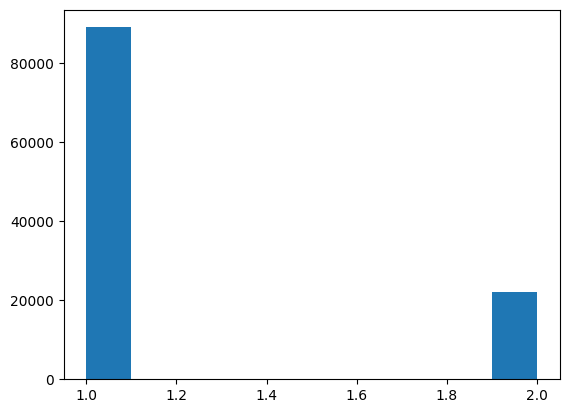

In [17]:
plt.hist(g.edge_attr)
plt.show()

Data(edge_index=[2, 202570], edge_attr=[202570], token_ids=[91294, 147], token_mask=[91294, 147], token_type_ids=[91294, 147])


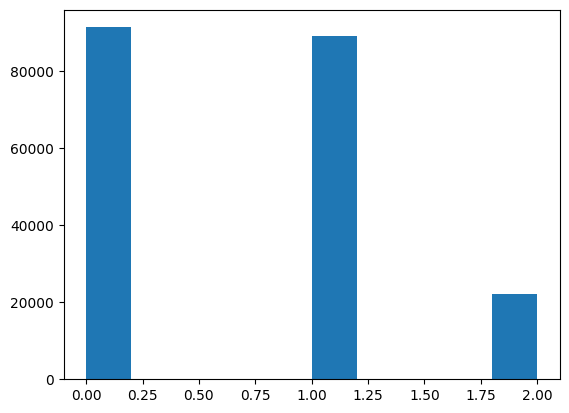

In [8]:
g = add_self_loops(data, g.token_ids.shape[0])
print(g)
plt.hist(g.edge_attr)
plt.show()

## Sampling, etc

In [7]:
# Selecting only hypernyms

edge_index = data.edge_index[:, data.edge_type == edge2id['Hypernyms']]

nodes_index = torch.concat([edge_index[0,:], edge_index[1,:]]).unique()
token_ids = data.token_ids[nodes_index]
token_mask = data.token_mask[nodes_index]
token_type_ids = data.token_type_ids[nodes_index]

hypernyms = Data()
hypernyms.edge_index = edge_index
hypernyms.token_ids = token_ids
hypernyms.token_mask = token_mask
hypernyms.token_type_ids = token_type_ids
hypernyms

Data(edge_index=[2, 89089], token_ids=[87943, 138], token_mask=[87943, 138], token_type_ids=[87943, 138])

### Edge sampling

from [Using Graph Neural Networks to Predict & Analyze Links in Friendship Networks](https://medium.com/@patwei/using-graph-neural-networks-to-predict-analyze-links-in-friendship-networks-5df020830ced)

In [29]:
from torch_geometric.utils import structured_negative_sampling
from sklearn.model_selection import train_test_split

In [26]:
src, tar, neg = structured_negative_sampling(g.edge_index)

In [35]:
idx = torch.arange(src.shape[0])
train_mask, test_mask = train_test_split(idx, test_size=0.2, stratify=g.edge_attr)

tensor([ 79764,   3191,  26426,  ...,   2925, 101044,  60177])

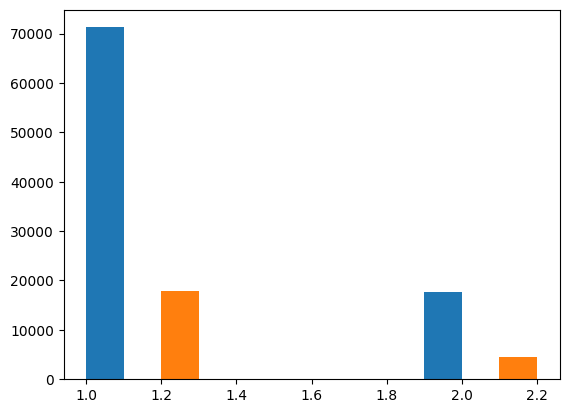

In [41]:
plt.hist(g.edge_attr[train_mask])
plt.hist(g.edge_attr[test_mask]+0.2)
plt.show()

In [10]:
# shuffle edges 
idx = torch.randperm(hypernyms.edge_index.shape[1])
hypernyms.edge_index = hypernyms.edge_index[:,idx]

In [12]:
# negative sampling
src, tar, neg = structured_negative_sampling(hypernyms.edge_index)

In [17]:
train_size = int(hypernyms.edge_index.shape[1] * 0.8)
val_size = int(hypernyms.edge_index.shape[1] * 0.1)
test_size = hypernyms.edge_index.shape[1] - train_size - val_size

hypernyms.pos_train_edge_index = torch.stack([src[:train_size], tar[:train_size]])
hypernyms.pos_val_edge_index = torch.stack([src[train_size:train_size+val_size], tar[train_size:train_size+val_size]])
hypernyms.pos_test_edge_index = torch.stack([src[train_size+val_size:], tar[train_size+val_size:]])
hypernyms.neg_train_edge_index = torch.stack([src[:train_size], neg[:train_size]])
hypernyms.neg_val_edge_index = torch.stack([src[train_size:train_size+val_size], neg[train_size:train_size+val_size]])
hypernyms.neg_test_edge_index = torch.stack([src[train_size+val_size:], neg[train_size+val_size:]])

### Subgraph sampling

like in [SEAL](https://arxiv.org/abs/1802.09691)

# PyG's Wordnet 

In [4]:
import torch 
from torch_geometric.datasets import WordNet18RR

wordnet = WordNet18RR(root='data/wordnet18rr', force_reload=True)

Processing...
Done!


In [5]:
edge_index = wordnet.edge_index
edge_type  = wordnet.edge_type 
train_mask, val_mask, test_mask = wordnet.train_mask, wordnet.val_mask, wordnet.test_mask

In [47]:
edge_type.shape, edge_type

(torch.Size([93003]), tensor([ 3,  9, 10,  ...,  3,  3,  3]))

In [6]:
wordnet.get(0)

Data(edge_index=[2, 93003], edge_type=[93003], train_mask=[93003], val_mask=[93003], test_mask=[93003], num_nodes=40943)

In [40]:
wordnet.edge2id

{'_also_see': 0,
 '_derivationally_related_form': 1,
 '_has_part': 2,
 '_hypernym': 3,
 '_instance_hypernym': 4,
 '_member_meronym': 5,
 '_member_of_domain_region': 6,
 '_member_of_domain_usage': 7,
 '_similar_to': 8,
 '_synset_domain_topic_of': 9,
 '_verb_group': 10}